In [ ]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/signatures"

**Data Preprocessing**

In [ ]:
# Creating lists of Genuine and fake signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
# Each person has 24 forged and 24 original examples
from natsort import natsorted, ns
orig_groups, forg_groups = [], []
images = os.listdir(path+"/full_forg")
images=natsorted(images, alg=ns.IGNORECASE)
images = [path+"/full_forg"+'/'+x for x in images]
for i in range(0,len(images)-1,24):
  forg_groups.append(images[i:i+24]) 
images = os.listdir(path+"/full_org")
images=natsorted(images, alg=ns.IGNORECASE)
images = [path+"/full_org"+'/'+x for x in images]
for i in range(0,len(images)-1,24):
  orig_groups.append(images[i:i+24])

In [ ]:
# Quick check to confirm we have data of all the 55 individuals
len(orig_groups), len(forg_groups)

(55, 55)

#### Train-Validation-Test Split
* Signatures of 42 people are used for training
* Signatures of 7 people are used for validation
* Signatures of 6 people are used for testing

In [ ]:
orig_train, orig_val, orig_test = orig_groups[:42], orig_groups[42:49], orig_groups[49:55]
forg_train, forg_val, forg_test = forg_groups[:42], forg_groups[42:49], forg_groups[49:55]

In [ ]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [ ]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        genuine_labels = []
        forged_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120
        # Total number of Genuine-Forged pairs = 120 * 300 = 36000
        # Total no. of data points = 33120 + 36000 = 69120
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        genuine_labels = [1]*len(orig_pairs)
        forged_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = genuine_labels + forged_labels
        del orig_pairs, forg_pairs, genuine_labels, forged_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # The lists above contain only the image names 
        # Actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that they are not added again in the next batch.
             
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        Y=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)

            '''Converting white patches to 255 pixel and black patches to 0 pixel for increasing accuracy'''
            for i in range(img1.shape[0]):
              for j in range(img1.shape[1]):
                pixel = img1.item(i, j)
                if pixel > 200:
                  img1[i][j]=255
                else:
                  img1[i][j]=0
            for i in range(img2.shape[0]):
              for j in range(img2.shape[1]):
                pixel = img2.item(i, j)
                if pixel > 200:
                  img2[i][j]=255
                else:
                  img2[i][j]=0
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            Y[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, Y
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))


In [ ]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [ ]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
#function tries to calculate the loss for genuine-genuine pairs by computing the euclidean distance 
#and the genuine-forged pairs by calculating the distance of the euclidean distance of the forged signature from the marginal boundary of the genuine signatures
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [ ]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2)))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, activation='relu'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, activation='relu')) # softmax changed to relu
    
    return seq

In [ ]:
#Image dimensions
input_shape=(img_h, img_w, 1)

In [ ]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [ ]:
batch_sz = 128
num_train_samples = 276*42 + 300*42
num_val_samples =  276*7 + 300*7 
num_test_samples =276*6 + 300*6 
num_train_samples, num_val_samples, num_test_samples

(24192, 4032, 3456)

In [ ]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

In [ ]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/signatures/signet-bhsig262-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [ ]:
results = model.fit_generator(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 100,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Epoch 1/100
189/189 [==============================] - ETA: 0s - loss: 1.3518
Epoch 00001: saving model to /content/drive/MyDrive/signatures/signet-bhsig262-001.h5
189/189 [==============================] - 1039s 5s/step - loss: 1.3518 - val_loss: 0.4993
Epoch 2/100
189/189 [==============================] - ETA: 0s - loss: 0.2682
Epoch 00002: saving model to /content/drive/MyDrive/signatures/signet-bhsig262-002.h5
189/189 [==============================] - 994s 5s/step - loss: 0.2682 - val_loss: 0.4983
Epoch 3/100
189/189 [==============================] - ETA: 0s - loss: 0.2575
Epoch 00003: saving model to /content/drive/MyDrive/signatures/signet-bhsig262-003.h5
189/189 [==============================] - 978s 5s/step - loss: 0.2575 - val_loss: 0.4335
Epoch 4/100
189/189 [==============================] - ETA: 0s - loss: 0.2371
Epoch 00004: saving model to /content/drive/MyDrive/signatures/signet-bhsig262-004.h5
189/189 [==============================] - 965s 5s/step - loss: 0.2371 - 

KeyboardInterrupt: ignored

After Seeing no improvement in model's performance on validation set, we decided to stop the training.


#### Load the weights from the epoch which gave the best validation accuracy

In [ ]:
model.load_weights('/content/drive/MyDrive/signatures/signet-bhsig262-005.h5')

In [ ]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

In [ ]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.7394918281781346, 0.1)

#### Accuracy = 73.949% and Threshold = 0.1
Thus if the difference score is less than 0.1, we predict the test image as Genuine and if the difference score is greater than 0.1, we predict it to be as forged

#### Below we see some sample results

In [ ]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

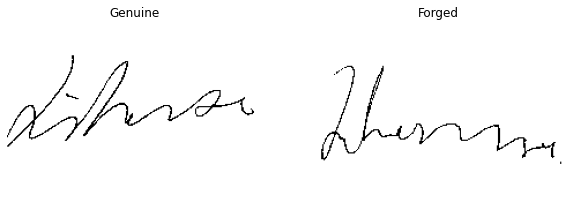

Difference Score =  0.38320112
Its a Forged Signature


In [ ]:
predict_score()

### The first image is always Genuine. Score prediction and classification is done for the second image

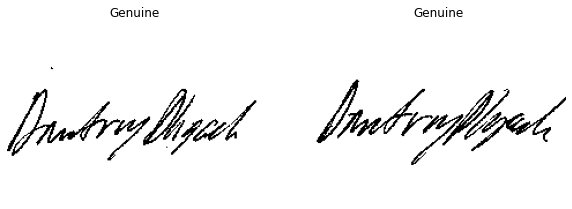

Difference Score =  0.0
Its a Genuine Signature


In [ ]:
predict_score()

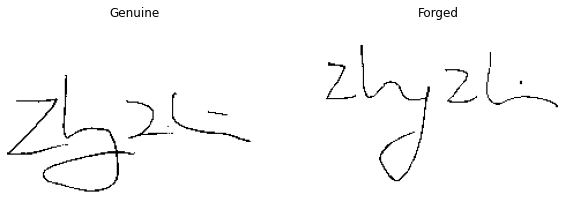

Difference Score =  0.38929915
Its a Forged Signature


In [ ]:
predict_score()

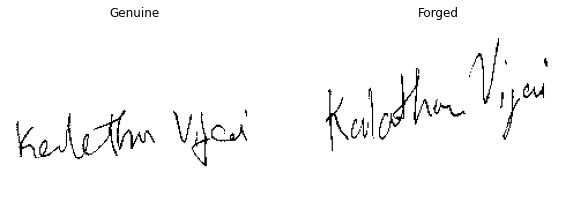

Difference Score =  0.3658068
Its a Forged Signature


In [ ]:
predict_score()

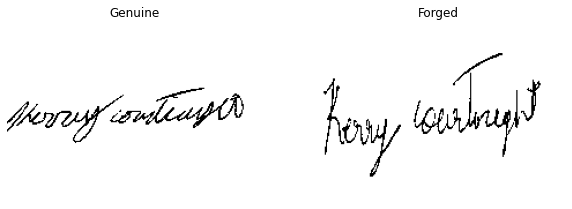

Difference Score =  0.3442968
Its a Forged Signature


In [ ]:
predict_score()

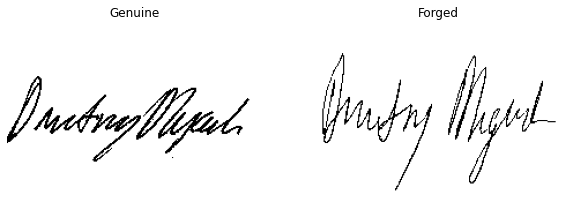

Difference Score =  0.7255243
Its a Forged Signature


In [ ]:
predict_score()

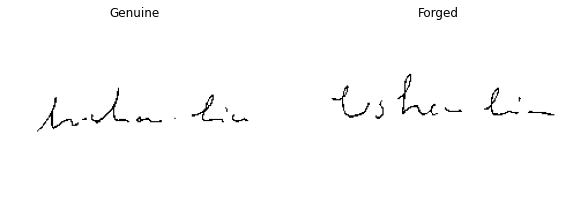

Difference Score =  0.06258801
Its a Genuine Signature


In [ ]:
predict_score()

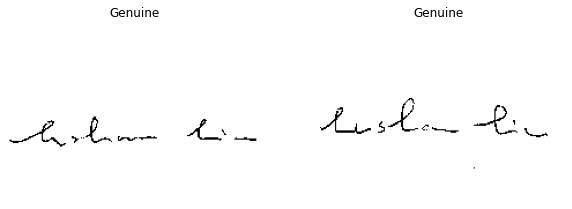

Difference Score =  0.13884996
Its a Forged Signature


In [ ]:
predict_score()